# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor


In [ ]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 3)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)


# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

date_today: 2025-08-01
date_last_6m: 2025-02-01
date_forecas: 2026-02-01


In [ ]:
query_str = """
SELECT 
  `FECHA_EJECUCION`,
  `FECHA`,
  `COV%`,
  `MAPE%`,
  `MODEL`,
  `NOMBREGRUPOESTADISTICO3`,
  `NOMBRESUBDIRECCION`,
  `Y_HIST`,
  `Y_PREDICCION`,
  `Y_PRONOSTICOS`,
  `Y_TEST`
FROM demanda-prj-dev.pronosticos.forecast_table
WHERE FECHA_EJECUCION = (
  SELECT MAX(FECHA_EJECUCION)
  FROM demanda-prj-dev.pronosticos.forecast_table
  )
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

forecast = query.to_dataframe(create_bqstorage_client=True)

forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)

forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)

forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)

forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [484]:
forecast.groupby(["FECHA","MODEL"]).agg({"Y_HIST":"sum","Y_PREDICCION": "sum", "Y_PRONOSTICOS":"sum", "Y_TEST": "sum"}).unstack(-1).tail(14)

Y_HIST                                                \
MODEL       BayesianRidge GradientBoostingRegressor KNeighborsRegressor   
FECHA                                                                     
2025-01-01  226907.334724             226862.341724       225533.033724   
2025-02-01  206222.409794             206206.540794       206563.302794   
2025-03-01  211971.978294             212046.655294       212951.784294   
2025-04-01  204230.657399             204099.363399       204184.936535   
2025-05-01  205286.256809             205248.805809       205232.678673   
2025-06-01  188664.514358             188768.157398       188855.223053   
2025-07-01  213178.545144             213263.082404       213176.655815   
2025-08-01  177930.893752             179391.308313       179673.526243   
2025-09-01       0.000000                  0.000000            0.000000   
2025-10-01       0.000000                  0.000000            0.000000   
2025-11-01       0.000000                  0.000000            0.000000   
2025-12-01       0.000000                  0.000000            0.000000   
2026-01-01       0.000000                  0.000000            0.000000   
2026-02-01       0.000000                  0.000000            0.000000   

                                                                               \
MODEL       LGBMRegressor RandomForestRegressor          Ridge            SVR   
FECHA                                                                           
2025-01-01  226879.686724         226904.103724  226901.320724  227086.060944   
2025-02-01  206172.902284         206129.486464  206223.749794  206344.978794   
2025-03-01  212083.796804         211992.024294  211971.785294  211975.736294   
2025-04-01  204090.886399         204123.931399  204230.446400  203698.235400   
2025-05-01  205249.084808         205224.939808  205288.296808  205241.848809   
2025-06-01  188774.455893         188781.965162  188658.268898  189106.893691   
2025-07-01  213188.583610         213340.543144  213177.929404  213258.089644   
2025-08-01  178159.762126         176702.147122  179608.063359  177576.989761   
2025-09-01       0.000000              0.000000       0.000000       0.000000   
2025-10-01       0.000000              0.000000       0.000000       0.000000   
2025-11-01       0.000000              0.000000       0.000000       0.000000   
2025-12-01       0.000000              0.000000       0.000000       0.000000   
2026-01-01       0.000000              0.000000       0.000000       0.000000   
2026-02-01       0.000000              0.000000       0.000000       0.000000   

                           Y_PREDICCION                            \
MODEL        XGBRegressor BayesianRidge GradientBoostingRegressor   
FECHA                                                               
2025-01-01  227059.750964  2.499164e+02                218.626421   
2025-02-01  206302.703284  1.734541e+03               1074.885921   
2025-03-01  211960.106804  1.560145e+12             207823.614199   
2025-04-01  204108.223400  6.949667e+13             203402.276893   
2025-05-01  205249.792758  4.410396e+11             202711.163336   
2025-06-01  188717.593711  6.136380e+05             198385.761229   
2025-07-01  213199.914038  6.552615e+11             196617.023851   
2025-08-01  176724.815729  3.976408e+12             187347.151561   
2025-09-01       0.000000  0.000000e+00                  0.000000   
2025-10-01       0.000000  0.000000e+00                  0.000000   
2025-11-01       0.000000  0.000000e+00                  0.000000   
2025-12-01       0.000000  0.000000e+00                  0.000000   
2026-01-01       0.000000  0.000000e+00                  0.000000   
2026-02-01       0.000000  0.000000e+00                  0.000000   

                                                                     \
MODEL      KNeighborsRegressor  LGBMRegressor RandomForestRegressor   
FECHA                                            

In [ ]:
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS FECHA,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS GE1,
nom_grupo_estadistico2 AS GE2,
nom_grupo_estadistico3 AS GE3,
sum(toneladas_pvo) AS PVO,
sum(toneladas_facturadas) AS FACT,
#sum(toneladas_mejor_pronostico) AS MAX,
sum(toneladas_plan_ventas) AS PV
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2025
AND
EXTRACT(YEAR FROM fecha) < 2026
-- Descartamos los siguientes campos
#AND
#nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
#AND
#nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

pv = query.to_dataframe(create_bqstorage_client=True)

pv.sort_index(inplace=True, ascending=True)

pv["PVO"] = pv["PVO"].astype(float)

pv["PV"] = pv["PV"].astype(float)

pv["FACT"] = pv["FACT"].astype(float).fillna(0)

#pv["MAX"] = pv["MAX"].astype(float)

pv["valid_ton"] = pv.PVO.fillna(0) + pv.FACT.fillna(0)

#pv = pv[pv["valid_ton"] > 0]

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


### Transformación de datos  

In [ ]:
df = forecast
# --- Define columns to extract ---
colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]

# --- First Filter: Y_PREDICCION ---
df1 = df[df["Y_PREDICCION"].notna()][colNames]

# --- Second Filter: Y_PRONOSTICOS ---
df2 = df[df["Y_PRONOSTICOS"].notna()][colNames2]
df2.columns = colNames  # Rename to match df1
# --- Combine both filtered datasets ---
combined_df = pd.concat([df1, df2], ignore_index=True)

# --- Reorder columns: move Y_PREDICCION next to MODEL ---
cols = combined_df.columns.tolist()

y_pred_idx = cols.index("Y_PREDICCION")

model_idx = cols.index("MODEL")

cols.insert(model_idx + 1, cols.pop(y_pred_idx))

combined_df = combined_df[cols]

combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

In [ ]:
res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")

cols_order = ["FECHA", "NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3", "BayesianRidge", "FACT", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "XGBRegressor", "SVR"]

out[cols_order]

,FECHA,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,BayesianRidge,FACT,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,XGBRegressor,SVR
0,2025-01-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON INDUSTRIAL,ALAMBRON INDUSTRIAL,NaN,4316.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR ANTAAC,NaN,9870.916,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR MYA,NaN,7265.782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRONES ESPECIALES,ALAMBRONES ESPECIALES,NaN,2394.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16588,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16589,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,COIL REBAR,37.057569,0.000,37.099456,34.18782,39.386679,37.733312,37.447743,45.11784,75.241048
16590,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,COIL REBAR - CANADA,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16591,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,SPOOL COIL REBAR,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = out.copy()

df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

df.FECHA = pd.to_datetime(df.FECHA)

#FILTRO LIMITE INFERIOR
df = df [df.FECHA >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.FECHA <= date_forecas]

df['Segmento'] = np.where ((df.FECHA >= date_last_6m) & (df.FECHA < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
df['WOC'] = df.mean(numeric_only = True, axis = 1)

df.groupby("FECHA").Segmento.last()

In [ ]:
display(df.isna().sum())

# imputamos 0s
df = df.fillna(0, inplace=False)

df.tail()

FECHA                            0
NombreGrupo                      0
NombreDireccion                  0
NombreSubdireccion               0
GE1                              0
GE2                              0
GE3                              0
PVO                           6073
FACT                             0
PV                            5822
valid_ton                        0
BayesianRidge                10058
GradientBoostingRegressor    10054
KNeighborsRegressor          10068
LGBMRegressor                10059
RandomForestRegressor        10059
Ridge                        10055
SVR                          10064
XGBRegressor                 10057
SUBG3                            0
Segmento                         0
WOC                              0
dtype: int64

,FECHA,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,SUBG3,Segmento,WOC
16588,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,KEY STEEL ACCOUNTS_VARILLA RESTO,Pronostico,0.000000
16589,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,COIL REBAR,0.0,0.0,0.0,0.0,37.057569,37.099456,34.18782,39.386679,37.733312,37.447743,75.241048,45.11784,KEY STEEL ACCOUNTS_COIL REBAR,Pronostico,34.327147
16590,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,COIL REBAR - CANADA,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,KEY STEEL ACCOUNTS_COIL REBAR - CANADA,Pronostico,0.000000
16591,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,SPOOL COIL REBAR,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,KEY STEEL ACCOUNTS_SPOOL COIL REBAR,Pronostico,0.000000
16592,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,VARILLA ROLLO,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,KEY STEEL ACCOUNTS_VARILLA ROLLO,Pronostico,0.000000


In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15208 entries, 1385 to 16592
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FECHA                      15208 non-null  datetime64[ns]
 1   NombreGrupo                15208 non-null  object        
 2   NombreDireccion            15208 non-null  object        
 3   NombreSubdireccion         15208 non-null  object        
 4   GE1                        15208 non-null  object        
 5   GE2                        15208 non-null  object        
 6   GE3                        15208 non-null  object        
 7   PVO                        15208 non-null  float64       
 8   FACT                       15208 non-null  float64       
 9   PV                         15208 non-null  float64       
 10  valid_ton                  15208 non-null  float64       
 11  BayesianRidge              15208 non-null  float64       
 12  Gradie

In [ ]:
cols2mape = df.columns [df.dtypes == float].to_list()

cols2mape.remove("FACT")

cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2):
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.mean()

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['SUBG3', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


In [477]:
(df==0).sum()

FECHA                                     0
NombreGrupo                               0
NombreDireccion                           0
NombreSubdireccion                        0
GE1                                       0
GE2                                       0
GE3                                       0
PVO                                    7649
FACT                                  10630
PV                                     7639
valid_ton                              7006
BayesianRidge                         10059
GradientBoostingRegressor             10054
KNeighborsRegressor                   10071
LGBMRegressor                         10059
RandomForestRegressor                 10059
Ridge                                 10055
SVR                                   10064
XGBRegressor                          10057
SUBG3                                     0
Segmento                                  0
WOC                                    6795
PVO_MAPE                        

In [ ]:
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

# eliminamos palabra AVG_MAPE_
df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

anakin = df.melt('MAX_Modelo', ignore_index = False)

df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    if df[col1] <= 0.1 and df[col2] <= 0.1:
        return 0
    elif df[col1] <= 0.1 and df[col2] > 0.1:
        return 1
    elif df[col1] > 0.1 and df[col2] <= 0.1:
        return 1
    else:
        return df[col1]/df[col2]

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)


# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,FECHA,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion
1385,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,Validacion,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PVO,0.000000,0.000000,Desviacion baja
1386,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON INDUSTRIAL,ALAMBRON INDUSTRIAL,4244.92490,2539.810,4244.92490,6784.73490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON INDUSTRIAL,Validacion,4453.598675,0.401683,0.401683,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.429717,0.254133,0.255018,0.246836,0.240218,0.248358,0.346222,0.245840,0.249201,0.358653,0.231776,0.161663,0.161663,WOC,4453.598675,1.049158,Desviacion alta
1387,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR ANTAAC,7691.32020,8371.606,7691.32020,16062.92620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON TREFILAR ANTAAC,Validacion,9954.293150,0.088449,0.088449,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.158995,0.211425,0.193545,0.299853,0.316187,0.726839,0.309345,0.336402,0.303686,0.425184,0.321580,0.153361,0.153361,WOC,9954.293150,1.294224,Desviacion alta
1388,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR MYA,6762.95367,7814.103,6762.95367,14577.05667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON TREFILAR MYA,Validacion,8979.266752,0.155428,0.155428,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.129762,0.228336,0.238553,0.466390,0.481463,0.998723,0.400890,0.676340,0.439497,0.491830,0.420697,0.156938,0.156938,WOC,8979.266752,1.327714,Desviacion alta
1389,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRONES ESPECIALES,ALAMBRONES ESPECIALES,2480.00003,2624.090,2480.00003,5104.09003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRONES ESPECIALES,Validacion,3172.045023,0.058101,0.058101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.172745,0.098734,0.092524,0.203824,0.205309,0.221840,0.194728,0.199943,0.203366,0.231138,0.213285,0.106491,0.092524,PV,2480.000030,1.000000,Desviacion alta


In [ ]:
df.groupby("SUBG3").MAX_Modelo.first().value_counts()

MAX_Modelo
PVO                          742
WOC                          471
BayesianRidge                194
GradientBoostingRegressor     34
Ridge                         29
PV                            16
XGBRegressor                  15
LGBMRegressor                 10
KNeighborsRegressor            8
RandomForestRegressor          6
SVR                            5
Name: count, dtype: int64

In [452]:
df.to_excel("Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [ ]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones

df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["FACT"], df["FCST"])
df

,FECHA,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion,FCST,TO_PLOT
1385,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.00000,0.000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,Validacion,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PVO,0.000000,0.000000,Desviacion baja,0.0,0.0
1386,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON INDUSTRIAL,ALAMBRON INDUSTRIAL,4244.92490,2539.810,4244.92490,6784.73490,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,INDUSTRIAS ACERÍAS_ALAMBRON INDUSTRIAL,Validacion,4453.598675,0.401683,0.401683,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.429717,0.254133,0.255018,0.246836,0.240218,0.248358,0.346222,0.245840,0.249201,0.358653,0.231776,0.161663,0.161663,WOC,4453.598675,1.049158,Desviacion alta,4453.598675,2539.81
1387,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR ANTAAC,7691.32020,8371.606,7691.32020,16062.92620,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,INDUSTRIAS ACERÍAS_ALAMBRON TREFILAR ANTAAC,Validacion,9954.293150,0.088449,0.088449,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.158995,0.211425,0.193545,0.299853,0.316187,0.726839,0.309345,0.336402,0.303686,0.425184,0.321580,0.153361,0.153361,WOC,9954.293150,1.294224,Desviacion alta,9954.29315,8371.606
1388,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON TREFILAR,ALAMBRON TREFILAR MYA,6762.95367,7814.103,6762.95367,14577.05667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,INDUSTRIAS ACERÍAS_ALAMBRON TREFILAR MYA,Validacion,8979.266752,0.155428,0.155428,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.129762,0.228336,0.238553,0.466390,0.481463,0.998723,0.400890,0.676340,0.439497,0.491830,0.420697,0.156938,0.156938,WOC,8979.266752,1.327714,Desviacion alta,8979.266752,7814.103
1389,2025-02-01,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRONES ESPECIALES,ALAMBRONES ESPECIALES,2480.00003,2624.090,2480.00003,5104.09003,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,INDUSTRIAS ACERÍAS_ALAMBRONES ESPECIALES,Validacion,3172.045023,0.058101,0.058101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.172745,0.098734,0.092524,0.203824,0.205309,0.221840,0.194728,0.199943,0.203366,0.231138,0.213285,0.106491,0.092524,PV,2480.000030,1.000000,Desviacion alta,2480.00003,2624.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16588,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,KEY STEEL ACCOUNTS_VARILLA RESTO,Pronostico,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.735360,0.435827,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.585350,0.435827,PV,0.000000,0.000000,Desviacion baja,0.0,0.0
16589,2025-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA ROLLO,COIL REBAR,0.00000,0.000,0.00

<Axes: xlabel='FECHA'>

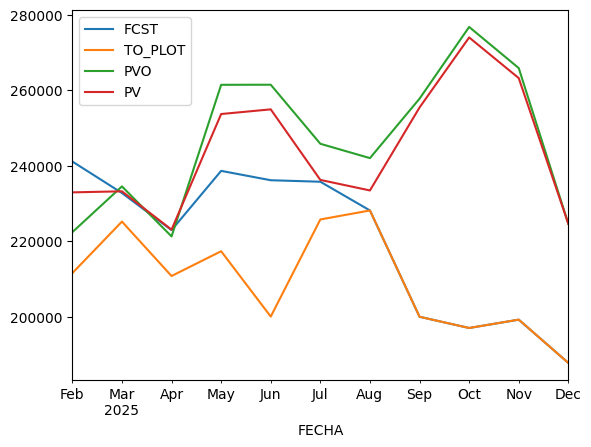

In [456]:
df.groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"}).plot()

In [ ]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones

df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion', df["FACT"], df["FCST"])

In [ ]:
df_2 = pd.read_excel(r"C:\Users\adojeda\Downloads\MejorPronostico2025-07-02.xlsx")

COLS2MAPE = df_2.columns[df_2.columns.str.contains("AVG_MAPE_")]

COLS2MAPE = [i.split("_")[-1] for i in COLS2MAPE]

condiciones = [df_2["MAX_Modelo"] == col  for col in COLS2MAPE]

valores = [df_2[col]  for col in COLS2MAPE]

# Valores a imputar según condiciones

df_2['FCST'] = np.select(condiciones, valores, default=None)

df_2["TO_PLOT"] = np.where(df_2.Segmento == 'Validacion',df_2["FACT"], df_2["FCST"])

,FECHA,GRUPO,DIRECCION,SUBDIRECCION,GE1,GE2,GE3,BR,FACT,GBR,KNR,LGBM,RFR,Ridge,SVR,XGB,WOC,Combinacion,Segmento,MAPE_LGBM,MAPE_BR,MAPE_XGB,MAPE_WOC,MAPE_RFR,MAPE_SVR,MAPE_GBR,MAPE_Ridge,MAPE_KNR,AVG_MAPE_LGBM,AVG_MAPE_BR,AVG_MAPE_XGB,AVG_MAPE_WOC,AVG_MAPE_RFR,AVG_MAPE_SVR,AVG_MAPE_GBR,AVG_MAPE_Ridge,AVG_MAPE_KNR,Min_MAPE,MAX_Modelo,MAX_Valores,FCST,TO_PLOT
0,2024-10-01,ACEROS,ACEROS MEXICO,MAYORISTAS ACEROS,PERFILES,REDONDOS Y CUADRADOS,REDONDOS COMERCIALES,29.845782,0.0,20.797603,9.373972,38.610728,23.034733,30.093537,9.508663,26.503136,23.471019,ACEROS_MAYORISTAS ACEROS_REDONDOS COMERCIALES,Validacion,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.545111,0.586898,0.575487,0.566503,0.619920,0.587575,0.569462,0.586150,0.642026,0.545111,LGBM,38.610728,38.610728,0.0
1,2024-10-01,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO INFRAESTRUCTURA,MALLAS Y ALAMBRES,NEGROS ANTAAC,ALAMBRE RECOCIDO,23.515600,0.0,65.397500,66.678800,7.915800,86.758000,23.755200,120.235500,76.591599,58.856000,DEACERO SOLUTIONS_COMERCIAL MEXICO INFRAESTRUC...,Validacion,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.111558,0.848254,0.934314,0.906962,0.940819,0.957413,0.916606,0.846482,0.923170,0.846482,Ridge,23.755200,23.7552,0.0
2,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,FASTENERS MCSW,50#,39.743650,0.0,37.114699,29.950836,29.701147,42.397420,39.528280,34.769658,43.952209,37.144737,USA_INDUSTRIAL WIRE_50#,Validacion,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.477314,0.422121,0.465246,0.432418,0.462497,0.489398,0.444436,0.427636,0.531230,0.422121,BR,39.743650,39.74365,0.0
3,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,INDUSTRIAL NEGROS,TENSILAC,192.442300,0.0,153.652200,149.696500,237.637100,151.031900,192.694600,163.957700,147.775208,173.610938,USA_INDUSTRIAL WIRE_TENSILAC,Validacion,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.609257,0.498944,0.601598,0.558170,0.631964,0.717091,0.489085,0.501809,0.723257,0.489085,GBR,153.652200,153.6522,0.0
4,2024-10-01,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,INDUSTRIAL NEGROS,UNIDAD DE COLCHON,50.816053,0.0,47.744872,64.818437,21.819148,38.208753,51.588633,50.249200,50.914597,47.019961,USA_INDUSTRIAL WIRE_UNIDAD DE COLCHON,Validacion,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.698989,0.540046,0.672281,0.635030,0.659321,0.638891,0.616293,0.551924,0.783720,0.540046,BR,50.816053,50.816053,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27715,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 1/2,5550.128800,0.0,3401.165000,3071.265500,2867.723300,5672.274400,6141.703500,3283.307200,1414.434204,3925.250238,USA_KEY STEEL ACCOUNTS_VARILLA 1/2,Pronostico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,3925.250238,3925.250238,3925.250238
27716,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 3/4,352.435144,0.0,130.617501,299.335445,249.084785,173.147040,115.210128,279.816098,117.569565,214.651963,USA_KEY STEEL ACCOUNTS_VARILLA 3/4,Pronostico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,214.651963,214.651963,214.651963
27717,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 3/8,3852.389800,0.0,5165.333900,5519.699100,3190.832000,2694.403600,7311.886500,5564.585000,1828.427612,4390.944689,USA_KEY STEEL ACCOUNTS_VARILLA 3/8,Pronostico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,WOC,4390.944689,4390.944689,4390.944689
27718,2028-12-01,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA 5/8,2768.026100,0.0,3378.578900,2332.741600,2673.794800,1391.800500,2272.532400,3196.865200,1188.460938,2400.350055,USA_KEY STEEL ACCOUNTS_VARILLA 5/8,Pronostico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0000

In [481]:
df_2[df_2.FECHA.dt.year == 2025].groupby(["FECHA","Segmento"]).agg({"FCST":"sum", "TO_PLOT":"sum"})

,,FCST,TO_PLOT
FECHA,Segmento,,
2025-01-01,Validacion,397797.371353,337579.820904
2025-02-01,Validacion,391052.664619,320410.55912
2025-03-01,Validacion,367188.253691,297143.962961
2025-04-01,Pronostico,360011.378652,360011.378652
2025-05-01,Pronostico,363936.243624,363936.243624
2025-06-01,Pronostico,211168.434913,211168.434913
2025-07-01,Pronostico,210346.477006,210346.477006
2025-08-01,Pronostico,207044.570856,207044.570856
2025-09-01,Pronostico,215365.616653,215365.616653


In [482]:
df.groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"})

,FCST,TO_PLOT,PVO,PV
FECHA,,,,
2025-02-01,241104.90701,211520.882999,222377.68809,232928.170940
2025-03-01,232753.794017,225183.701193,234503.16216,233206.947570
2025-04-01,222926.838839,210759.987656,221252.29368,223043.938370
2025-05-01,238624.796686,217325.344704,261432.81623,253691.165190
2025-06-01,236142.274626,200007.724365,261455.95843,254927.625660
2025-07-01,235744.277752,225748.418331,245805.59441,236226.078790
2025-08-01,228130.471451,228130.471451,242005.21309,233433.499990
2025-09-01,199955.691308,199955.691308,257763.80122,255424.672228
2025-10-01,196982.847922,196982.847922,276768.89225,273982.324383
